Do some machine learning

In [1]:
from dataPrep import prepJoinedNursingHomeData
from dataPrep import preprocessData
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [2]:
nursingHomeData = prepJoinedNursingHomeData()
trainX, trainY, testX, testY = preprocessData(nursingHomeData)

Now we have our data prepared, lets try a few models randomly just to see how they preform, below is a quick reminder of the distribution of our labels, and a calculation of what percentage of our dataset is the majority class.

We also separate out a valdiation set to allow us to see how our models perform on data they haven't seen without spoiling our test data

In [3]:
valTrainX, valX, valTrainY, valY = train_test_split(trainX, trainY, test_size=0.33, random_state=42)

In [4]:
trainY.value_counts()

No Different than the National Rate    5052
Better than the National Rate          1242
Worse than the National Rate            419
Name: FacilityReadmissionScore, dtype: int64

In [5]:
trainY.value_counts()[0]/trainY.shape[0]

0.7525696409950842

In [6]:
clf = linear_model.RidgeClassifier().fit(trainX, trainY)
cross_val_score(clf, trainX, trainY, cv=4).mean()

0.7549533925707808

In [7]:
clf = svm.SVC(kernel='linear', C=1).fit(trainX, trainY)
cross_val_score(clf, trainX, trainY, cv=4).mean()

0.7525696910798116

In [8]:
clf = HistGradientBoostingClassifier().fit(trainX, trainY)
cross_val_score(clf, trainX, trainY, cv=4).mean()

0.7559947035560215

Clearly our models are all struggling to represent the data, lets see how with a confusion matrix

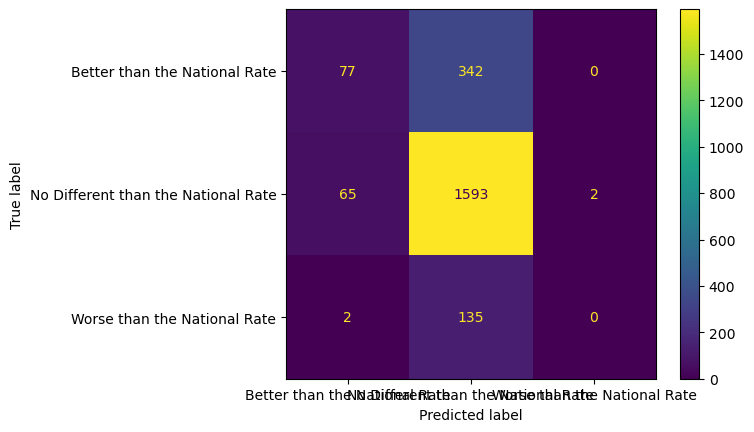

In [9]:
clf = HistGradientBoostingClassifier().fit(valTrainX, valTrainY)
yPred = clf.predict(valX)
ConfusionMatrixDisplay.from_predictions(valY, yPred)

In [10]:
print(classification_report(valY, yPred))

                                     precision    recall  f1-score   support

      Better than the National Rate       0.53      0.18      0.27       419
No Different than the National Rate       0.77      0.96      0.85      1660
       Worse than the National Rate       0.00      0.00      0.00       137

                           accuracy                           0.75      2216
                          macro avg       0.43      0.38      0.38      2216
                       weighted avg       0.68      0.75      0.69      2216



Our model over predicts the majority class

Meanwhile on training data we perform well, we have some overfitting issues

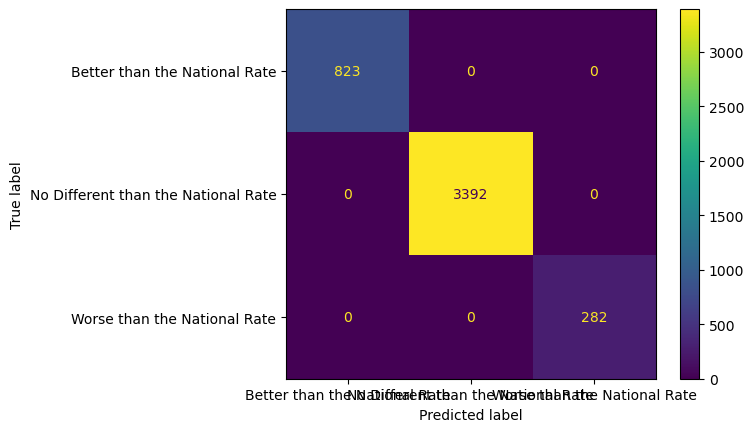

In [11]:
yPred = clf.predict(valTrainX)
ConfusionMatrixDisplay.from_predictions(valTrainY, yPred)

In [12]:
clf.score(valTrainX, valTrainY)

1.0

Lets see if we can reduce the number of features we use to those that make our model perform best without having so much data that we overfit easily; as we have a large number of uncorrelated features, there is plenty of variation to fit to, so maybe with less variation we can obtain a more generalizable fit. XGBoost is used as its relatively efficient and sequential feature selector is very computationaly expensive.

To do this with/without PCA an option was added to the data preprocessing function to allow for removal of PCA.

Re-running the above without PCA based feature selection and min/max scaling instead of standard scaling, there are no notable significant changes in performance.

In [13]:
clf = xgb.XGBClassifier(n_estimators=20, max_depth=4)
#as XGBoost expects numeric classification labels, encode our labels as numbers
le = LabelEncoder().fit(valTrainY)
numericalValTrainY = le.transform(valTrainY)

sfs = SequentialFeatureSelector(clf, n_features_to_select=10, cv=3)
sfs.fit(valTrainX, numericalValTrainY)

SequentialFeatureSelector(cv=3,
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
              

              precision    recall  f1-score   support

           0       0.67      0.06      0.11       419
           1       0.76      0.99      0.86      1660
           2       0.50      0.01      0.01       137

    accuracy                           0.75      2216
   macro avg       0.64      0.35      0.33      2216
weighted avg       0.72      0.75      0.66      2216



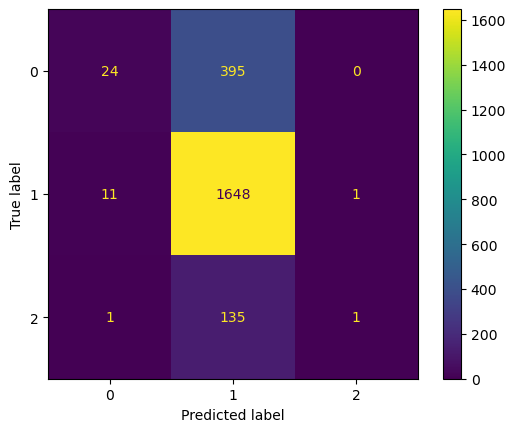

In [14]:
FSvalTrainX = sfs.transform(valTrainX)
FSvalX = sfs.transform(valX)
clf = xgb.XGBClassifier(n_estimators=20, max_depth=4).fit(FSvalTrainX, numericalValTrainY)
yPred = clf.predict(FSvalX)
numericalValY = le.transform(valY)
print(classification_report(numericalValY, yPred))
ConfusionMatrixDisplay.from_predictions(numericalValY, yPred)

for comparison our performance on the data we trained on is below. If nothing else now we are overfitting less.

              precision    recall  f1-score   support

           0       0.85      0.09      0.16       823
           1       0.77      1.00      0.87      3392
           2       1.00      0.02      0.04       282

    accuracy                           0.77      4497
   macro avg       0.87      0.37      0.36      4497
weighted avg       0.80      0.77      0.69      4497



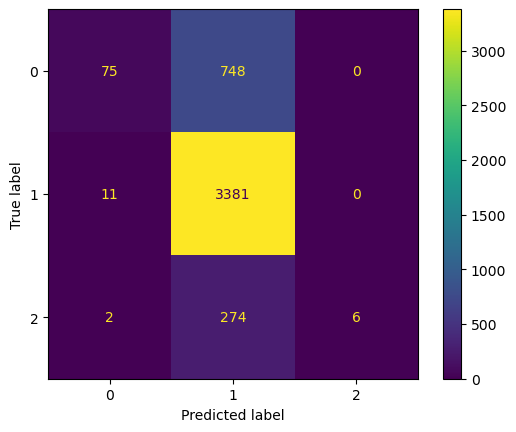

In [15]:
yPred = clf.predict(FSvalTrainX)
print(classification_report(numericalValTrainY, yPred))
ConfusionMatrixDisplay.from_predictions(numericalValTrainY, yPred)

Or comparatively without feature selection as a baseline for XGBoost we get:

              precision    recall  f1-score   support

           0       0.52      0.10      0.16       419
           1       0.76      0.98      0.85      1660
           2       0.00      0.00      0.00       137

    accuracy                           0.75      2216
   macro avg       0.43      0.36      0.34      2216
weighted avg       0.67      0.75      0.67      2216



C:\Users\Mint\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mint\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mint\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


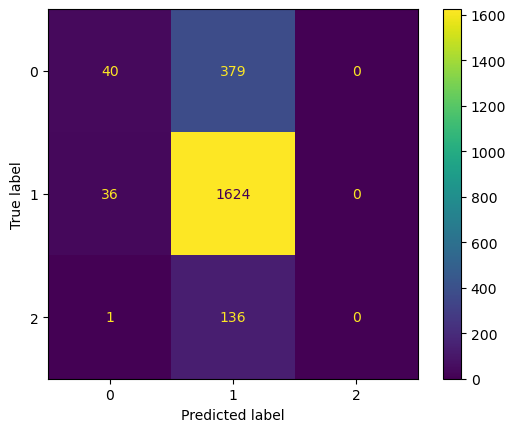

In [16]:
clf = xgb.XGBClassifier(n_estimators=20, max_depth=4).fit(valTrainX, numericalValTrainY)
yPred = clf.predict(valX)
numericalValY = le.transform(valY)
print(classification_report(numericalValY, yPred))
ConfusionMatrixDisplay.from_predictions(numericalValY, yPred)

Nothing much has worked so far, lets try not imputing with KNN and see if that improves our models performance, as XGBoost handles NaN values internally by default.

In [17]:
trainX, trainY, testX, testY = preprocessData(nursingHomeData, doImpute=False, doPCA = False, scalerType="standard")
valTrainX, valX, valTrainY, valY = train_test_split(trainX, trainY, test_size=0.33, random_state=42)

numericalValTrainY = le.transform(valTrainY)
numericalValY = le.transform(valY)

              precision    recall  f1-score   support

           0       0.74      0.32      0.45       419
           1       0.79      0.97      0.87      1660
           2       0.00      0.00      0.00       137

    accuracy                           0.79      2216
   macro avg       0.51      0.43      0.44      2216
weighted avg       0.73      0.79      0.74      2216



C:\Users\Mint\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mint\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mint\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


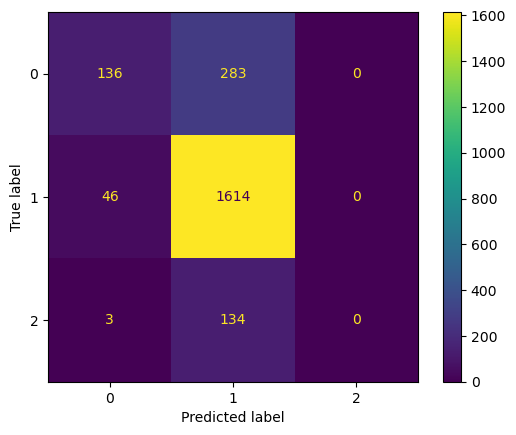

In [18]:
clf = xgb.XGBClassifier(n_estimators=20, max_depth=4).fit(valTrainX, numericalValTrainY)
yPred = clf.predict(valX)
print(classification_report(numericalValY, yPred))
ConfusionMatrixDisplay.from_predictions(numericalValY, yPred)

While not stelar we can tell that if nothing else imputing using KNN did in fact reduce the accuracy of our model.

We can see that we are overfitting less as well, our performance is more comparable between training and testing data.   
(performance on validation data above, performance on training data below)

              precision    recall  f1-score   support

           0       0.85      0.49      0.62       823
           1       0.83      0.98      0.90      3392
           2       1.00      0.07      0.13       282

    accuracy                           0.83      4497
   macro avg       0.89      0.51      0.55      4497
weighted avg       0.85      0.83      0.80      4497



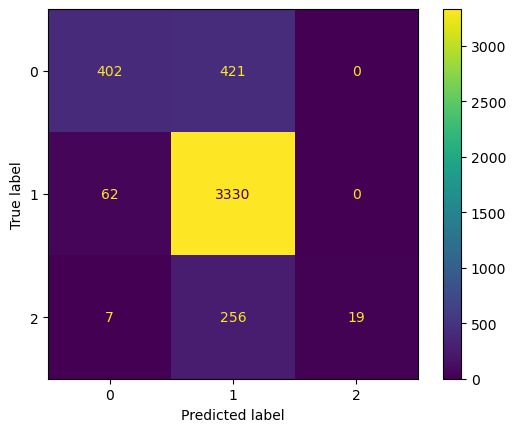

In [19]:
yPred = clf.predict(valTrainX)
print(classification_report(numericalValTrainY, yPred))
ConfusionMatrixDisplay.from_predictions(numericalValTrainY, yPred)